In [1]:
import json

import numpy as np
from scipy.integrate import quad
from scipy.stats import norm
from scipy.optimize import minimize

from matplotlib import pyplot as plt, scale as mscale, colors, cm
import cmasher

from tqdm import tqdm

EPSILON = np.finfo(float).eps

In [2]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{bm}')
plt.rcParams['figure.figsize'] = [5.5, 1.7]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.titlesize'] = 'small'
plt.rcParams['axes.titlepad'] = 3
plt.rcParams['xtick.labelsize'] = 'x-small'
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize']
plt.rcParams['legend.fontsize'] = 6.5
plt.rcParams['legend.handlelength'] = 1.2
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.edgecolor'] = '#333'
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.7
plt.rcParams['patch.linewidth'] = 0.7
plt.rcParams['hatch.linewidth'] = 0.7
plt.rcParams['axes.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.6
plt.rcParams['xtick.major.width'] = 0.6
plt.rcParams['xtick.minor.width'] = 0.4
plt.rcParams['ytick.major.width'] = plt.rcParams['xtick.major.width']
plt.rcParams['ytick.minor.width'] = plt.rcParams['xtick.minor.width']

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
R_P = np.linspace(0, 0.5, 200)

def get_R_Q(kQ_kR, sigma):
    sq = np.sqrt((1 + kQ_kR) * (1 + sigma ** 2 * np.tan(np.pi * R_P) ** 2))
    return np.arccos(1 / sq) / np.pi

In [4]:
with open('metrics_mnist_to_ardis_binary_v1.json', 'r') as f:
    data = json.load(f)

mnist_accuracies = {k: v for k, v in zip(data['model_ids'], data['accuracy']['mnist'])}
ardis_accuracies = {k: v for k, v in zip(data['model_ids'], data['accuracy']['ardis'])}
list(mnist_accuracies)

['ridgeclassifier0',
 'ridgeclassifier1',
 'ridgeclassifier10',
 'logisticregression_l2_1',
 'logisticregression_l2_10',
 'logisticregression_l1_1',
 'logisticregression_l1_10',
 'rfn64',
 'rfn128',
 'rfn256',
 'rfn512',
 'rfn1k',
 'rfn2k',
 'mlp1_64d',
 'mlp2_64d_64d',
 'mlp1_512d',
 'mlp2_512d_512d',
 'mlp1_4096d',
 'mlp2_4096d_4096d',
 'alexnet',
 'alexnet_val_acc0.5',
 'alexnet_val_acc0.7',
 'alexnet_val_acc0.8',
 'alexnet_val_acc0.9',
 'vgg11',
 'vgg11_val_acc0.5',
 'vgg11_val_acc0.6',
 'vgg11_val_acc0.7',
 'vgg11_val_acc0.8',
 'vgg11_val_acc0.9',
 'vgg16',
 'vgg16_val_acc0.5',
 'vgg16_val_acc0.6',
 'vgg16_val_acc0.7',
 'vgg16_val_acc0.8',
 'vgg16_val_acc0.9',
 'resnet18',
 'resnet18_val_acc0.5',
 'resnet18_val_acc0.6',
 'resnet18_val_acc0.7',
 'resnet18_val_acc0.8',
 'resnet18_val_acc0.9',
 'resnet50',
 'resnet50_val_acc0.5',
 'resnet50_val_acc0.6',
 'resnet50_val_acc0.7',
 'resnet50_val_acc0.8',
 'resnet50_val_acc0.9',
 'densenet121',
 'densenet121_val_acc0.5',
 'densenet121_val

In [5]:
model_sequences = {
    'ridgeclassifier': [
        'ridgeclassifier0',
        'ridgeclassifier1',
        'ridgeclassifier10',
    ],
    'logisticregression_l2': [
        'logisticregression_l2_1',
        'logisticregression_l2_10',
    ],
    'logisticregression_l1': [
        'logisticregression_l1_1',
        'logisticregression_l1_10',
    ],
    'rfn': [
        'rfn64',
        'rfn128',
        'rfn256',
        'rfn512',
        'rfn1k',
        'rfn2k',
    ],
    'mlp1': [
        'mlp1_64d',
        'mlp1_512d',
        'mlp1_4096d',
    ],
    'mlp2': [
        'mlp2_64d_64d',
        'mlp2_512d_512d',
        'mlp2_4096d_4096d',
    ],
    'alexnet': [
        'alexnet_val_acc0.5',
        'alexnet_val_acc0.7',
        'alexnet_val_acc0.8',
        'alexnet_val_acc0.9',
        'alexnet',
    ],
    'vgg11': [
        'vgg11_val_acc0.5',
        'vgg11_val_acc0.6',
        'vgg11_val_acc0.7',
        'vgg11_val_acc0.8',
        'vgg11_val_acc0.9',
        'vgg11',
    ],
    'vgg16': [
        'vgg16_val_acc0.5',
        'vgg16_val_acc0.6',
        'vgg16_val_acc0.7',
        'vgg16_val_acc0.8',
        'vgg16_val_acc0.9',
        'vgg16',
    ],
    'resnet18': [
        'resnet18_val_acc0.5',
        'resnet18_val_acc0.6',
        'resnet18_val_acc0.7',
        'resnet18_val_acc0.8',
        'resnet18_val_acc0.9',
        'resnet18',
    ],
    'resnet50': [
        'resnet50_val_acc0.5',
        'resnet50_val_acc0.6',
        'resnet50_val_acc0.7',
        'resnet50_val_acc0.8',
        'resnet50_val_acc0.9',
        'resnet50',
    ],
    'densenet121': [
        'densenet121_val_acc0.5',
        'densenet121_val_acc0.6',
        'densenet121_val_acc0.7',
        'densenet121_val_acc0.8',
        'densenet121_val_acc0.9',
        'densenet121',
    ],
    'densenet161': [
        'densenet161_val_acc0.5',
        'densenet161_val_acc0.6',
        'densenet161_val_acc0.7',
        'densenet161_val_acc0.8',
        'densenet161_val_acc0.9',
        'densenet161',
    ]
}

In [6]:
def get_sequence_accuracies(name):
    
    sequence = model_sequences[name]
    mnist_means = []
    ardis_means = []
    for model in sequence:
        mnist_means.append(np.mean(mnist_accuracies[model]))
        ardis_means.append(np.mean(ardis_accuracies[model]))
    
    return mnist_means, ardis_means

def get_sequence_stds(name):
    
    sequence = model_sequences[name]
    mnist_stds = []
    ardis_stds = []
    for model in sequence:
        mnist_stds.append(np.std(mnist_accuracies[model]))
        ardis_stds.append(np.std(ardis_accuracies[model]))
    
    return mnist_stds, ardis_stds

def fit_curve(acc_P, acc_Q):
    
    risk_P = 1 - np.asarray(acc_P)
    risk_Q = 1 - np.asarray(acc_Q)
    
    def mse(kQ_kR, sigma, min_bias=False):
        R_Q = get_R_Q(kQ_kR, sigma)
        fit_risk_Q = np.interp(risk_P, R_P, R_Q)
        if min_bias:
            weight_factor = np.exp(-30 * (risk_P - np.argmin(risk_P)))
            weight_factor /= np.sum(weight_factor)
            return ((risk_Q - fit_risk_Q) ** 2) @ weight_factor
        else:
            return np.mean((risk_Q - fit_risk_Q) ** 2)
        
    kQ_kR, sigma = 1, 1
    
    for t in range(2):
        res = minimize(lambda x: mse(x, sigma, True), kQ_kR, bounds=[(1e-6, None)])
        kQ_kR = res.x[0]
        res = minimize(lambda x: mse(kQ_kR, x), kQ_kR, bounds=[(1e-6, None)])
        sigma = res.x[0]
    
    return kQ_kR, sigma

In [7]:
fit_params = {}

for name in tqdm(model_sequences):
    if name in fit_params:
        continue
    kQ_kR, sigma = fit_curve(*get_sequence_accuracies(name))
    fit_params[name] = kQ_kR, sigma

fit_params

100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 44.22it/s]


{'ridgeclassifier': (9.935786796184898, 1e-06),
 'logisticregression_l2': (2.3429680894162757, 1.0195999476022424),
 'logisticregression_l1': (0.9999862054571511, 0.468941652397494),
 'rfn': (2.7959508441667467, 1e-06),
 'mlp1': (1.9745758680001602, 1.9745758680001602),
 'mlp2': (1.9764679620147907, 1.9764679620147907),
 'alexnet': (0.10533715548300114, 1.251675491058301),
 'vgg11': (0.0655698660494085, 1.7415436813335061),
 'vgg16': (0.11447747145916067, 2.2381654287511092),
 'resnet18': (0.17231968583138055, 5.062359932466361),
 'resnet50': (0.12755717090836327, 2.0357546209347666),
 'densenet121': (0.0678034343387991, 1.0549819678079326),
 'densenet161': (0.05018576789084303, 0.9898370295281552)}

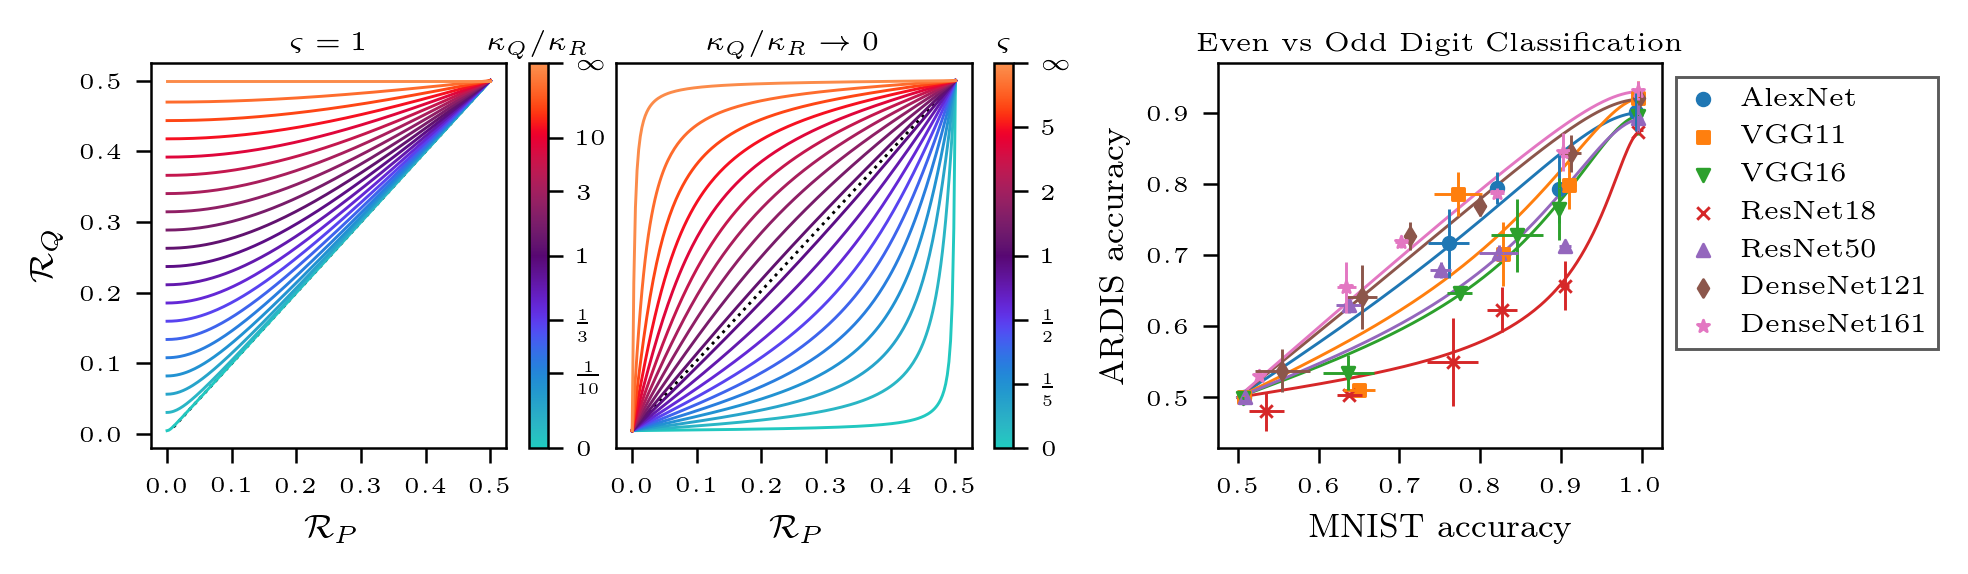

In [8]:
plot_names = {
    'alexnet': 'AlexNet',
    'vgg11': 'VGG11',
    'vgg16': 'VGG16',
    'resnet18': 'ResNet18',
    'resnet50': 'ResNet50',
    'densenet121': 'DenseNet121',
    'densenet161': 'DenseNet161'
}

kQ_kRs_interp = np.asarray([x ** 2 / (1 - x **2) for x in np.linspace(EPSILON, 1 - EPSILON, 500)])
limiting_risks_interp = np.asarray([get_R_Q(kQ_kR, 1)[0] for kQ_kR in kQ_kRs_interp])

def kQ_kR_scale_fun(x):
    return np.interp(x, 2 * limiting_risks_interp, kQ_kRs_interp)

def kQ_kR_scale_fun_inv(y):
    return np.interp(y, kQ_kRs_interp, 2 * limiting_risks_interp)

kQ_kRs_lin = np.linspace(1e-2, 1 - 1e-2, 20)
kQ_kRs = [kQ_kR_scale_fun(x) for x in kQ_kRs_lin]
sigma = 1

cmap = cmasher.guppy_r
sm = cm.ScalarMappable(cmap=cmap)
    
################

fig, axes = plt.subplots(1, 3, figsize=(6.5, 1.7), dpi=300)

ax = axes[0]

ax.plot([1e-2, 0.5], [1e-2, 0.5], ':k')

for kQ_kR in kQ_kRs:
    R_Q = get_R_Q(kQ_kR, sigma)
    ax.plot(R_P, R_Q, color=cmap(kQ_kR_scale_fun_inv(kQ_kR)))
    
ax.set_title(r'$\varsigma = 1$')
cbar = fig.colorbar(sm, ax=ax, ticks=[kQ_kR_scale_fun_inv(x) for x in [0, 1/10, 1/3, 1, 3, 10]] + [1])
cbar.ax.set_yticklabels([0, r'$\frac{1}{10}$', r'$\frac{1}{3}$', 1, 3, 10, r'$\infty$'])
cbar.ax.set_title(r'$\kappa_Q / \kappa_R$')

ax.set_xticks(np.arange(6) / 10)
ax.set_yticks(np.arange(6) / 10)
ax.set_xlabel('$\mathcal{R}_P$')
ax.set_ylabel('$\mathcal{R}_Q$')

####################################################

def sigma_scale_fun(x):
    return x / (1 - x)

def sigma_scale_fun_inv(y):
    return 1 - 1 / (1 + y)

sigmas_lin = np.linspace(0.01, 0.99, 20)
sigmas = [sigma_scale_fun(x) for x in sigmas_lin]
kQ_kR = EPSILON

################

ax = axes[1]
ax.plot([1e-2, 0.5], [1e-2, 0.5], ':k')

for sigma in sigmas:
    R_Q = get_R_Q(kQ_kR, sigma)
    ax.plot(R_P, R_Q, color=cmap(sigma_scale_fun_inv(sigma)))
    
ax.set_title(r'$\kappa_Q / \kappa_R \to 0$')
cbar = fig.colorbar(sm, ax=ax, ticks=[sigma_scale_fun_inv(x) for x in [0, 1/5, 1/2, 1, 2, 5]] + [1])
cbar.ax.set_yticklabels([0, r'$\frac{1}{5}$', r'$\frac{1}{2}$', 1, 2, 5, r'$\infty$'])
cbar.ax.set_title(r'$\varsigma$')

ax.set_xticks(np.arange(6) / 10)
ax.set_yticks(np.arange(6) / 10)
ax.set_yticks([])
ax.set_xlabel('$\mathcal{R}_P$')

# custom positioning
shift_amount = 0.035
l, r, w, h = ax.get_position().bounds
ax.set_position((l - shift_amount, r, w, h), 'both')
l, r, w, h = cbar.ax.get_position().bounds
cbar.ax.set_position((l - shift_amount, r, w, h), 'both')

####################################################

ax = axes[2]

markers = ['o', 's', 'v', 'x', '^', 'd', '*']

for i, (name, color, marker) in enumerate(zip(plot_names, color_cycle, markers)):
    
    mnist_acc, ardis_acc = get_sequence_accuracies(name)
    ax.scatter(mnist_acc, ardis_acc, color=color, label=plot_names[name], marker=marker)
    
    mnist_std, ardis_std = get_sequence_stds(name)
    ax.errorbar(mnist_acc, ardis_acc, yerr=ardis_std, xerr=mnist_std, fmt=',', color=color)

    kQ_kR, sigma = fit_params[name]
    R_Q = get_R_Q(kQ_kR, sigma)
    ax.plot(1 - R_P, 1 - R_Q, color=color, zorder=-1)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Even vs Odd Digit Classification')
ax.set_xlabel('MNIST accuracy')
ax.set_ylabel('ARDIS accuracy')

#plt.tight_layout()

plt.savefig('classification_risk_shifts.pdf', bbox_inches='tight')
plt.show()

In [9]:
def squared_error(z1, z2):
    return np.mean((z1 - z2) ** 2)

def zero_one_loss(z1, z2):
    return np.mean((z1 * z2 < 0).astype(float))

def log_loss(z1, z2):
    return np.mean(np.log(1 + np.exp(-np.sign(z1) * z2)))

def hinge_loss(z1, z2):
    return np.mean(np.maximum(1 - np.sign(z1) * z2, 0))

100%|████████████████████████████████████████| 200/200 [00:00<00:00, 480.41it/s]


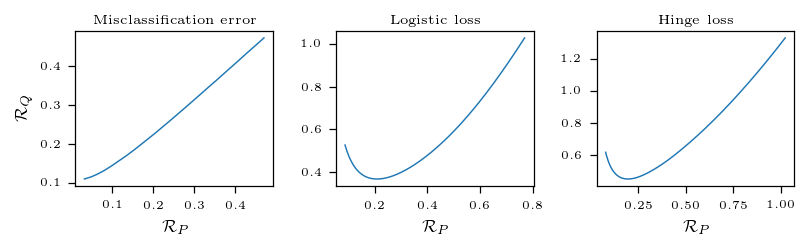

In [10]:
n = 10 ** 5

rho = 5
sigma_beta = 1
kappa_Q = 0.1
kappa_R = 0.8
varsigma = 1
kappa_P = 1 - kappa_Q - kappa_R
sigma_E = 1

theta = np.sqrt(rho * kappa_R / (kappa_R + kappa_P))
sigma_Z = np.sqrt(kappa_R + kappa_P) * sigma_beta
sigma_W = np.sqrt(rho * kappa_Q) * sigma_beta
alphas = np.logspace(-1, 1, 200)

Z = np.random.randn(n) * sigma_Z
E = np.random.randn(n) * sigma_E
W = np.random.randn(n) * sigma_W

losses = [zero_one_loss, log_loss, hinge_loss]
loss_names = ['Misclassification error', 'Logistic loss', 'Hinge loss']

plt.figure(dpi=150)

for k, (ell, name) in enumerate(zip(losses, loss_names)):
    
    plt.subplot(1, len(losses), k + 1)

    error_d1 = np.zeros(len(alphas))
    error_d2 = np.zeros(len(alphas))

    for i, alpha in enumerate(tqdm(alphas)):
        error_d1[i] = ell(Z, alpha * Z + E)
        error_d2[i] = ell(theta * Z + W, theta * (alpha * Z + varsigma * E))

    plt.plot(error_d1, error_d2)
    plt.title(name)
    plt.xlabel('$\mathcal{R}_P$')
    if k == 0:
        plt.ylabel('$\mathcal{R}_Q$')

plt.tight_layout()
plt.savefig('logistic_hinge_losses.pdf', bbox_inches='tight')
plt.show()